# $\mathrm{DNN \: Inversion \: of \: RESOLVE}$
## 周波数領域電磁探査法(RESOLVE)データの深層学習を用いた水平多層構造解析
入力セルを編集後、全てのセルを実行してください。

## 各種ライブラリのインポート

In [1]:
# Built-in : 
import sys, os
import json
# Dependent : 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Local script : 
sys.path.append('../../')
from script import ModelingToolKit as mtk
from script import GenerateDataset as gd
from script import networks
from script import resume

## 入力セル

In [2]:
network_name = 'sample02'

"""
層厚の設定
　学習データの生成から地下構造の内、層数と層厚は固定されます。
　入力値は層数、表層の厚さ、最終層の上端深度、層厚の等分割スケールの４つです。
　全n層の内、表層と最終層の間は線形スケールまたは対数スケールで(n-2)等分されます。
　一層ずつ手入力で決めることもできます。
"""
# semi-auto
thickness = mtk.tmake(0.5, 150, 30, scale='log')
# manual
# thickness = []

"""
人口学習データの生成とRESOLVEに関する設定
"""
# 学習に用いる比抵抗構造-磁場応答データの数
dataset_size = 5000

# バックグラウンド比抵抗の範囲 (Ohm-m)
resistivity_range = [10, 1000]

# バード高さの上限下限 (m)
bird_height_range = [10, 100]

# RESOLVEの測定周波数(降順, Hz)
freqs = [140000, 31000, 6600, 3300, 1500, 340]

# 各コイルの送受信間隔 (m)
spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]

# ノイズの付与　on : = True, off : = False
add_noise = False

# ノイズレベル（付与するノイズの標準偏差, ppm)
noise_level = [50, 40, 30, 20, 10, 10]

# 比抵抗構造生成モード 現状、'normal'で固定
generate_mode = 'default'

bird_height_in_x = True


"""
ニューラルネットワークの学習に関する設定
"""

# バッチサイズ　値が大きいほど学習時間は短くなります。
batch_size = 500
# エポック回数 値が小さいほど学習時間が短くなります。
epochs = 100

"""
深層学習解析を適用するフィールドデータの入力
"""
# 探査フィールドまたはプロジェクト名
field_name = 'sendai_plains'

# フィールドデータのファイルのパス
fielddata_filepath = "../../field_data/HEM_line_base_mini.csv"

IDHeader = [
    'Line', 'FID', 'UTC_TIME'
]

LocHeader = [
    'X', 'Y', 'topo'
]

EMHeader = [
    'CPI140K', 'CPI31K', 'CPI6900', 'CXI3300', 'CPI1500', 'CPI340',
    'CPQ140K', 'CPQ31K', 'CPQ6900', 'CXQ3300', 'CPQ1500', 'CPQ340',
#    'EM4I', 'EM1I', 'EM2I', 'EM6I', 'EM5I', 'EM3I',
#    'EM4Q', 'EM1Q', 'EM2Q', 'EM6Q', 'EM5Q', 'EM3Q',
]
BHHeader = 'ALTBIRDR'

# 測定データファイルの欠損オブジェクト
nan_char = ['*']

"""
出力設定
"""

log_scale_layerview = True

## 1. 層構造の決定

In [3]:
depth = mtk.dmake(thickness)
mtk.show_structure(thickness, depth)

層境界深度 (m)
  0.000 |   0.500 |   0.613 |   0.751 |   0.921 |   1.129 |   1.385 |   1.697 |   2.081 |   2.551 | 
  3.127 |   3.834 |   4.700 |   5.762 |   7.064 |   8.660 |  10.617 |  13.016 |  15.956 |  19.562 | 
 23.981 |  29.400 |  36.042 |  44.185 |  54.169 |  66.407 |  81.411 |  99.805 | 122.355 | 150.000 | 
層厚 (m)
  0.500 |   0.113 |   0.138 |   0.170 |   0.208 |   0.255 |   0.313 |   0.384 |   0.470 |   0.576 | 
  0.707 |   0.866 |   1.062 |   1.302 |   1.596 |   1.957 |   2.399 |   2.941 |   3.605 |   4.420 | 
  5.418 |   6.643 |   8.143 |   9.983 |  12.239 |  15.004 |  18.394 |  22.550 |  27.645 | infinity|


interactive(children=(IntSlider(value=30, description='~ Layer No.', layout=Layout(width='100%'), max=30, min=…

## 2. データ生成

In [4]:
config = {
    'size' : dataset_size,
    'thicks' : thickness,
    'bgrlim' : resistivity_range,
    'bhlim' : bird_height_range,
    'freqs' : freqs,
    'spans' : spans,
    'add_noise' : add_noise,
    'noise_level' : noise_level,
    'generate_mode' : generate_mode,
    'bhinx' : bird_height_in_x
}

dataset_dir = 'result/'
dsetfile_path = dataset_dir + network_name + '_dataset.csv'

model_dir = 'network/'
histfile_path = model_dir + network_name + '_history.csv'
nnetfile_path = model_dir + network_name + '_network.h5'

if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
    tofit = False
    print('The Specified Dataset & Neural Network Model Already Exists.')
else:
    resolve = gd.Resolve1D(**config)
    data = resolve.proceed()
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    tofit = True
    print("-> /" + dsetfile_path)

-> /result/sample02_dataset.csv


## 3. ニューラルネットワークの学習

In [5]:
# 説明変数の次元
nx = 2 * len(freqs) + int(bird_height_in_x)
# 層数
nlayer = len(depth)

#分割
x = df.iloc[:, :nx].values
y = df.iloc[:, nx:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()

#正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# 新しいデータセットが用意された場合、学習を実行する
if tofit:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


Epoch 1/100
10/10 - 1s - loss: 3.1848 - val_loss: 0.8543
Epoch 2/100
10/10 - 0s - loss: 0.8991 - val_loss: 0.2819
Epoch 3/100
10/10 - 0s - loss: 0.5336 - val_loss: 0.2093
Epoch 4/100
10/10 - 0s - loss: 0.4343 - val_loss: 0.1614
Epoch 5/100
10/10 - 0s - loss: 0.3749 - val_loss: 0.1638
Epoch 6/100
10/10 - 0s - loss: 0.3436 - val_loss: 0.1584
Epoch 7/100
10/10 - 0s - loss: 0.3243 - val_loss: 0.1313
Epoch 8/100
10/10 - 0s - loss: 0.3152 - val_loss: 0.1384
Epoch 9/100
10/10 - 0s - loss: 0.2950 - val_loss: 0.1241
Epoch 10/100
10/10 - 0s - loss: 0.2884 - val_loss: 0.1606
Epoch 11/100
10/10 - 0s - loss: 0.2754 - val_loss: 0.1388
Epoch 12/100
10/10 - 0s - loss: 0.2704 - val_loss: 0.1259
Epoch 13/100
10/10 - 0s - loss: 0.2634 - val_loss: 0.1655
Epoch 14/100
10/10 - 0s - loss: 0.2608 - val_loss: 0.1146
Epoch 15/100
10/10 - 0s - loss: 0.2498 - val_loss: 0.1540
Epoch 16/100
10/10 - 0s - loss: 0.2405 - val_loss: 0.1666
Epoch 17/100
10/10 - 0s - loss: 0.2420 - val_loss: 0.1113
Epoch 18/100
10/10 - 0s

## 4. 評価・テスト

#### 4.1 学習中のMSE遷移

<Figure size 432x288 with 0 Axes>

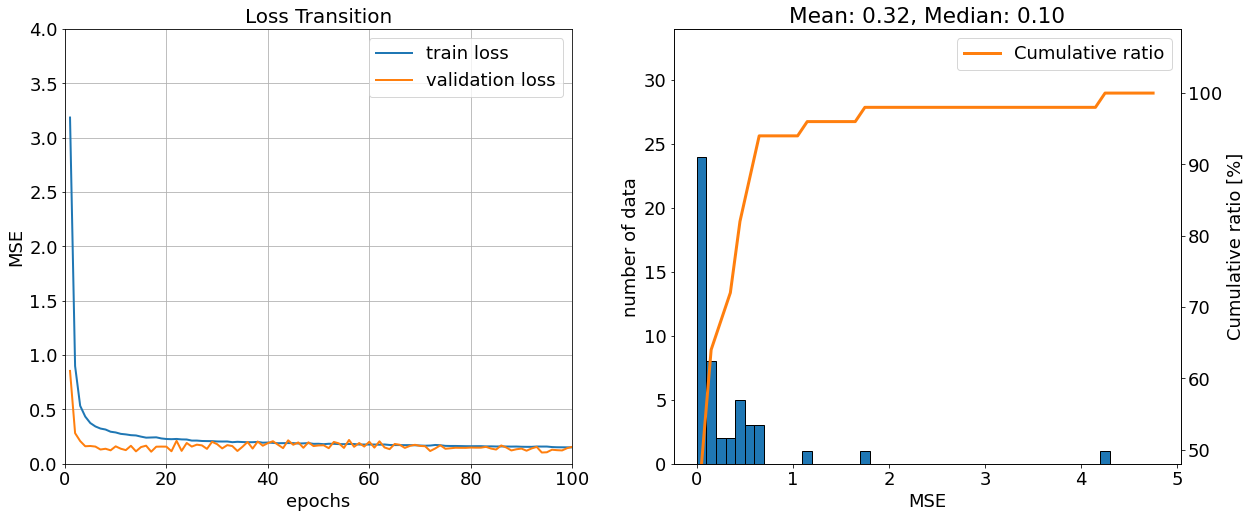

In [6]:
plt.rcParams["font.size"] = 18
plt.tight_layout()
epochx = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
ax1.plot(epochx, loss, label='train loss', linewidth=2)
ax1.plot(epochx, val_mse, label='validation loss', linewidth=2)
ax1.set_xlabel('epochs')
ax1.set_ylabel('MSE')
ax1.set_xlim(0, epochx.max())
ax1.set_ylim(0, loss.max() // 1 + 1)
ax1.legend()
ax1.grid()
ax1.set_title('Loss Transition', fontsize = 20)

terr = (y_test - network.predict(x_test))**2
tmse = np.array([k.mean() for k in terr])

ax2 = fig.add_subplot(122)
max_mse = tmse.max()
nbins = int(max_mse // 0.1) + 7
bins = [.1*(i) for i in range(nbins)]
n, bins, patches = ax2.hist(tmse, bins=bins, edgecolor='k')
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax2.set_xlabel('MSE')
ax2.set_ylabel('number of data')
mean = np.mean(tmse)
median = np.median(tmse)
ax2.set_ylim(0, n.max()+10)
ax2.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx2 = ax2.twinx()
lines = bx2.plot(x2, y2, ls='-', color='C1', linewidth=3, label='Cumulative ratio')
bx2.set_ylim(10 * y2.min() // 10, 109)
bx2.set_ylabel('Cumulative ratio [%]')
bx2.legend(loc='upper right');

## 5. DL解析

In [8]:
save_path = "result/" + field_name + "_" + network_name + ".csv"

datafile_format = fielddata_filepath.split(sep='.')[-1]

pickup_columns = IDHeader + LocHeader + EMHeader + [BHHeader]
if bird_height_in_x:
    XVHeader = EMHeader + [BHHeader]
else:
    XVHeader = EMHeader

numlayer = len(depth)
RESHeader = ['R{}'.format(i+1) for i in range(numlayer)]

if os.path.exists(save_path):
    print('the result has already saved.')
    pass

else:
    if datafile_format == 'csv':
        data = pd.read_csv(fielddata_filepath)
        dfd = data.loc[:, pickup_columns].values
        df = pd.DataFrame(dfd, columns=pickup_columns)
        # 欠損値を含む行
        for c in nan_char:
            df = df.replace(c, np.nan)
        
        for xh in XVHeader:
            df = df[df[xh] != np.nan]

        x = df[XVHeader].values
        ide = df[IDHeader].values
        loc = df[LocHeader].values

        stdx = sc.transform(x)
        res = network.predict(stdx)
        res = 10 ** res

        header = [*pickup_columns, *RESHeader]
        rdata = np.hstack([ide, loc, x, res])
        rdf = pd.DataFrame(rdata)
        rdf.to_csv(save_path, header=header, index=False)
        print('the result is saved at ' + save_path)
    else:
        print('datafile format must be csv')

the result has already saved.


## 6. 比抵抗断面図の作成

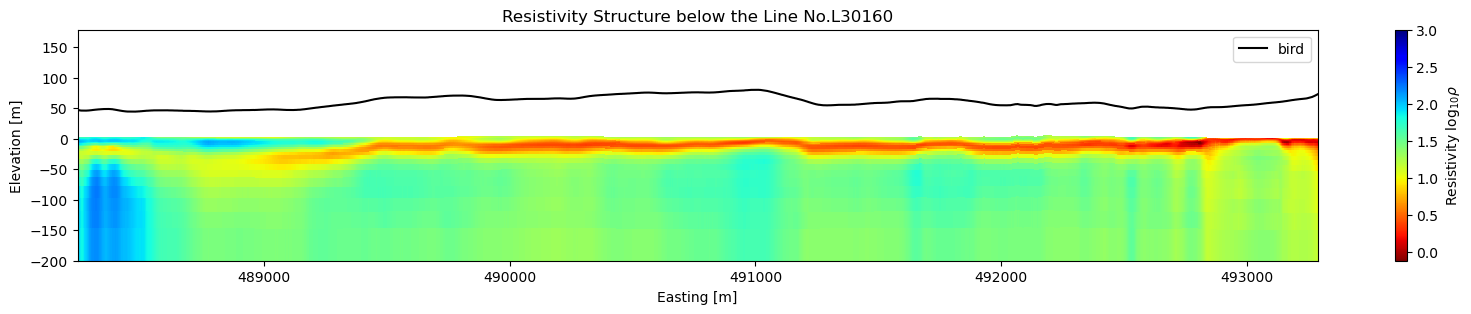

In [9]:
df = pd.read_csv(save_path)
lines = df[IDHeader[0]].values
line_no_list = []
logg = 0
for nomb in lines:
    if nomb == logg:
        logg = nomb
    else:
        line_no_list.append(nomb)
        logg = nomb

lineno = line_no_list[3]

inline = df[df[IDHeader[0]]==lineno]

easting = inline[LocHeader[0]].values
northing = inline[LocHeader[1]].values
elevation = inline[LocHeader[2]].values
height = inline[XVHeader[-1]].values

res = inline[RESHeader].values
res = np.log10(res)

resmax = np.log10(1000)
resmin = res.min()
cres = (res-resmin)/(resmax-resmin)
cmaps = plt.cm.jet_r(cres)

depthadd = np.append(depth, 2*depth.max())
plt.style.use('default')
fig = plt.figure(figsize=(20, 3), dpi=100)
ax = fig.add_subplot(111)
ax.grid()
ax.set(xlim=(easting.min(), easting.max()), ylim=(-depth.max()+elevation.min()-50, height.max()+100))
for i in range(easting.shape[0]-1):
    mesh_x, mesh_y = np.meshgrid(easting[i:i+2], -depthadd+elevation[i])
    cross_section = ax.pcolormesh(mesh_x, mesh_y, res[i].reshape(len(res[i]), 1), vmin=resmin, vmax=resmax, cmap='jet_r', shading='flat')

norm = mpl.colors.Normalize(vmin=resmin, vmax=resmax)
m = mpl.cm.ScalarMappable(cmap=plt.cm.jet_r, norm=norm)
m.set_array([])
fig.colorbar(m, label='Resistivity ${\log_{10}{ρ}}$')
ax.plot(easting, elevation+height, color='k', label='bird')
ax.legend()
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Elevation [m]')
ax.set_title('Resistivity Structure below the Line No.{}'.format(lineno));

## 設定の保存

In [10]:
# 設定の保存
settings = {
    'network' : {
        'name' : network_name,
        'epochs' : epochs,
        'batch_size' : batch_size,

    },
    'subsurface' : {
        'thickness' : list(thickness),
        'depth' : list(depth)

    },
    'resolvedataset' : {
        'dataset_size' : dataset_size,
        'resistivity_range' : resistivity_range,
        'bird_height_range' : bird_height_range,
        'frequency' : freqs,
        'separetion' : spans,
        'add_noise' : add_noise,
        'noise_level' : noise_level,
        'generate_mode' : generate_mode,
        'bird_height_in_x' : bird_height_in_x
    },
    'fielddata' : {
        'field_name' : field_name,
        'fielddata_filepath' : fielddata_filepath,
        'nan_char' : nan_char
    }
}
with open(f'result/config_{network_name}_{field_name}.json', 'w') as fp:
    json.dump(settings, fp, indent=4)